# Tutorial 4: Mouse Spleen Dataset

In this tutorial, we analyse the dataset of two mouse spleen sections based on SPOTS (Spatial PrOtein and Transcriptome Sequencing)

All datasets used in this paper are available at https://doi.org/10.5281/zenodo.14854747.

## Loading package

In [1]:
import warnings
warnings.filterwarnings('ignore')

import torch
import anndata
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix

import os
## Should be replaced with the R package installation path
os.environ['R_HOME'] = 'E:/R-4.3.1'
os.environ['R_USER'] = 'E:/anaconda/lib/site-packages/rpy2'

import sys
sys.path.append(r'..')
from Model.INR import INRModel
from Model.utils import mclust_R, reorder_categories
from Model.model import DCCAE
from Model.preprocess import fix_seed, preprocessing
fix_seed(2024)

## Loading data and preprocessing

In [2]:
adata_modality_1 = sc.read_h5ad("../Data/Mouse_Spleen_1/adata_RNA.h5ad")
adata_modality_2 = sc.read_h5ad("../Data/Mouse_Spleen_1/adata_ADT.h5ad")

adata_modality_1.var_names_make_unique()
adata_modality_2.var_names_make_unique()

fix_seed(2024)
adata_modality_1, adata_modality_2 = preprocessing(adata_modality_1, adata_modality_2, 'SPOTS')
adata_modality_1.X = adata_modality_1.uns['INR']
adata_modality_2.obsm['X_pca'] = adata_modality_2.uns['INR']
sc.pp.pca(adata_modality_1)

SPOTS data preprocessing have done!
Dimensions after preprocessed adata_modal_1: (2568, 3000)
Dimensions after preprocessing adata_modal_2: (2568, 21)


## Training the model

### INR module

All parameters of the INR model remain the same across the two slices.

| replicate | epoch of modality 1 | epoch of modality 2 |
|:------:|:------:|:------:|
| 1 |  500  |  500  |
| 2 |  500 |  500  |

In [ ]:
## INR module training
def Spatially_Continuous_Reconstruction(adata, epoch_num):
    coords = adata.obsm['spatial'].astype(np.float32)
    node_feats = adata.X.astype(np.float32)

    coords = torch.from_numpy(coords).float()
    if isinstance(node_feats, csr_matrix):
        node_feats = node_feats.toarray()
    node_feats = torch.from_numpy(node_feats).float()
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    node_feats = node_feats.to(device)
    coords = coords.to(device)
    
    print(f'out_dim: {node_feats.shape[1]}')

    model = INRModel(
        X=node_feats,
        spatial_coord=coords,
        device=device,
        learning_rate=1e-4,
        reg_par=0,
        epoch_num=epoch_num,
        print_train_log_info=True
    )

    reconstructed_X = model.fit()
    if 'INR' not in adata.uns:
        adata.uns['INR'] = reconstructed_X

# modality 1
Spatially_Continuous_Reconstruction(adata_modality_1, 500)

# modality 2
Spatially_Continuous_Reconstruction(adata_modality_2, 500)

### DCCAE module

In [ ]:
n_output = 21
features1 = adata_modality_1.obsm['X_pca'].shape[1]  # Feature sizes
features2 = adata_modality_2.obsm['X_pca'].shape[1]
layers1 = [256, 256, n_output]  # nodes in each hidden layer and the output size
layers2 = [256, 256, n_output]

X = adata_modality_1.obsm['X_pca'].copy()
Y = adata_modality_2.obsm['X_pca'].copy()

use_rep = ['DCCAE_X', "DCCAE_Y", "DCCAE"]
n_DCCA = 10
epochs = 150
model = DCCAE(input_size1=features1, input_size2=features2, n_components=n_DCCA, layer_sizes1=layers1, layer_sizes2=layers2, epoch_num=epochs)
model.fit([X, Y])
Xs_transformed = model.transform([X, Y])
adata_modality_1.obsm["DCCAE_X"] =  Xs_transformed[0]
adata_modality_2.obsm["DCCAE_Y"] =  Xs_transformed[1]
adata_modality_1.obsm["DCCAE"] = np.concatenate((adata_modality_1.obsm["DCCAE_X"], adata_modality_2.obsm["DCCAE_Y"]),axis=1)

Training Progress:   0%|          | 0/150 [00:00<?, ?it/s]

Training Progress: 100%|██████████| 150/150 [00:19<00:00,  7.61it/s]


model training finished!


In [ ]:
use_rep = ['DCCAE_X', 'DCCAE_Y', 'DCCAE']
mclust_R(adata_modality_1, used_obsm=use_rep[2], num_cluster=6)

fitting ...
  |======================================================================| 100%


AnnData object with n_obs × n_vars = 2568 × 3000
    obs: 'clusters_mclust'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'INR', 'hvg', 'log1p', 'pca', 'clusters_mclust_colors'
    obsm: 'spatial', 'X_pca', 'DCCAE_X', 'DCCAE'
    varm: 'PCs'

## Visualization

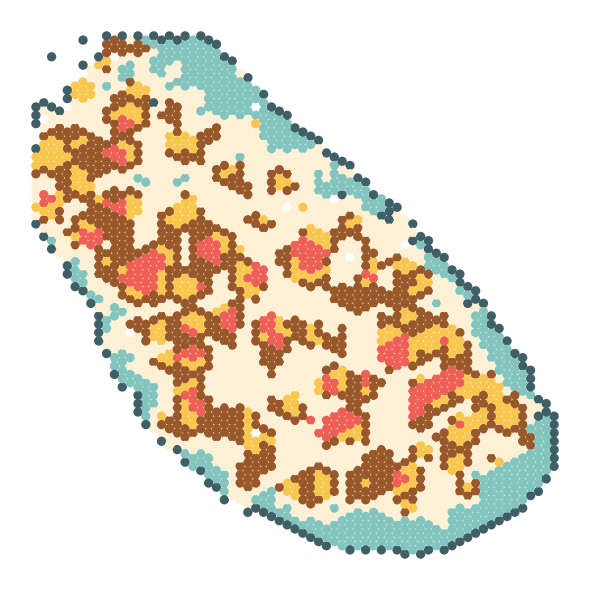

In [ ]:
adata_analysis = sc.read_h5ad("D:/study/learning/spatial_transcriptome/papers/spatial_multi_omics-main/Results/Mouse_Spleen_Replicate1.h5ad")

colors = [
    '#fdf0d5', '#f9c74f', '#83c5be', '#99582a', '#3f5e66', '#ee6055'
]

fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
sc.pl.embedding(adata_analysis, basis='spatial', color='SpaKnit', ax=ax, s=180, show=False, palette=colors)
ax.set_title(f'')
ax.set_xlabel('')
ax.set_ylabel('')
# remove legend
ax.get_legend().remove()
for spine in ax.spines.values():
    spine.set_visible(False)
plt.tight_layout()

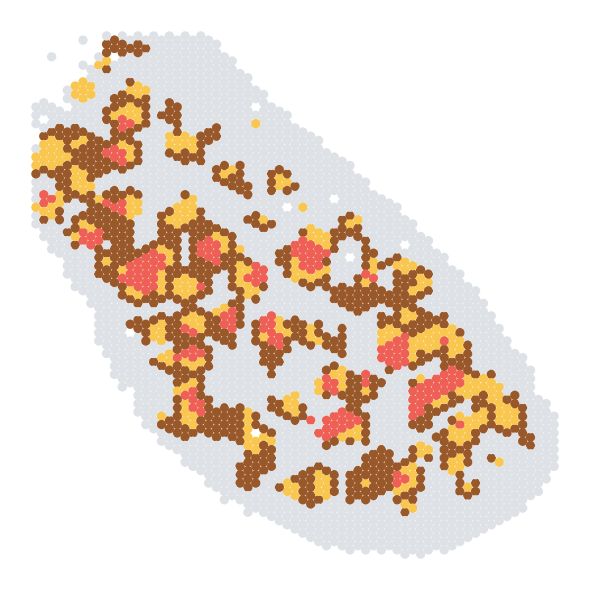

In [ ]:
colors = [
    '#dee2e6', '#f9c74f', '#dee2e6', '#99582a', '#dee2e6', '#ee6055'
]

fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
sc.pl.embedding(adata_analysis, basis='spatial', color='SpaKnit', ax=ax, s=180, show=False, palette=colors)
ax.set_title(f'')
ax.set_xlabel('')
ax.set_ylabel('')
# remove legend
ax.get_legend().remove()
for spine in ax.spines.values():
    spine.set_visible(False)
plt.tight_layout()

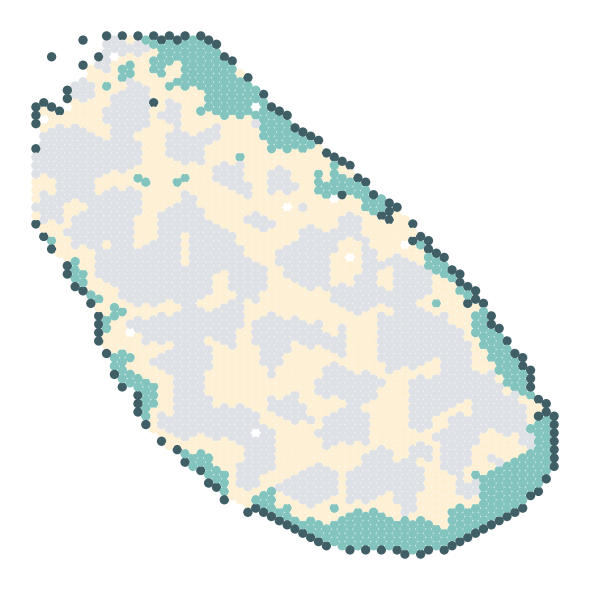

In [5]:
colors = [
    '#fdf0d5', '#dee2e6', '#83c5be', '#dee2e6', '#3f5e66', '#dee2e6'
]
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
sc.pl.embedding(adata_analysis, basis='spatial', color='SpaKnit', ax=ax, s=180, show=False, palette=colors)
ax.set_title(f'')
ax.set_xlabel('')
ax.set_ylabel('')
# remove legend
ax.get_legend().remove()
for spine in ax.spines.values():
    spine.set_visible(False)
plt.tight_layout()

In [ ]:
## Restoring the results
# obs store the clustering results
# uns store the integrated embeddings
# adata_SpaKnit = anndata.AnnData()
# adata_SpaKnit = anndata.AnnData()
# adata_SpaKnit.obs['SpaKnit'] = adata_modality_1.obs['clusters_mclust']
# adata_SpaKnit.obsm['SpaKnit'] = adata_modality_1.obsm['DCCAE']
# adata_SpaKnit.obsm['spatial'] = adata_modality_1.obsm['spatial']
# adata_SpaKnit.write_h5ad('./Results/Mouse_Spleen_Replicate1.h5ad')

## Identifying the marker genes

In [ ]:
## calculate the marker genes
sc.tl.dendrogram(adata_modality_1, groupby='clusters_mclust')
sc.tl.rank_genes_groups(adata_modality_1, groupby='clusters_mclust', use_raw=False)

rank_genes = sc.get.rank_genes_groups_df(adata_modality_1, group=None)
rank_genes.to_excel("./Results/Visualization/Mouse_Spleen/Replicate2/" + 'Replicate2_marker_genes.xlsx', index=True)

## Histological Validation of Mouse Spleen Structures 
The Histological image of mouse spleen replicate 1 is processed using standard image-processing techniques (filtering and binarization) to identify vesicular germinal centers (GCs) and smooth macrophage-enriched regions.

### germinal centers (GCs)

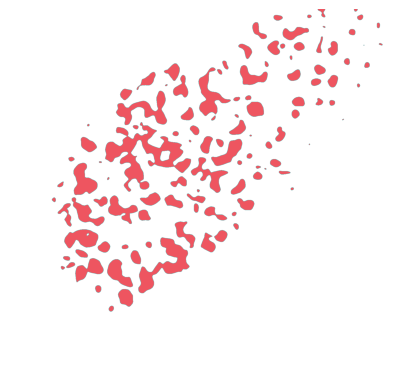

In [ ]:
import cv2

# Open the image file
image_path = r"D:/study/learning/spatial_transcriptome/papers/spatial_multi_omics-main/data/Mouse_Spleen_1/tissue_hires_image.png"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Get the height and width of the image
height, width, _ = image.shape

# Calculate the start and end coordinates for the cropping area
start_x = int(width * 0.15)  # Start at 15% of the width
start_y = int(height * 0.08)  # Start at 8% of the height
end_x = int(width * 0.9)  # End at 90% of the width
end_y = int(height * 0.85)  # End at 85% of the height

# Crop the middle 80% of the image
image = image[start_y:end_y, start_x:end_x]

image = cv2.GaussianBlur(image, (51, 51), 0)

# Convert the image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Perform binary thresholding; the threshold value can be adjusted according to the actual situation
_, binary_image = cv2.threshold(gray_image, 185, 255, cv2.THRESH_BINARY)

# Create a black image of the same size as the original image for drawing the binary red and blue regions, and add an alpha channel
result_image = np.zeros((image.shape[0], image.shape[1], 4), dtype=np.uint8)

# Set the transparency of red and blue, ranging from 0 to 255, with higher values being less transparent
red_alpha = 255  # Transparency of red
blue_alpha = 0  # Transparency of blue
## BGR
result_image[binary_image == 255] = [238, 85, 96, red_alpha]  # Red
result_image[binary_image == 0] = [0, 120, 120, blue_alpha]  # Blue

# Find the connected regions of the red area
red_mask = result_image[:, :, 0] > 0  # Mask for the red area
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(red_mask.astype(np.uint8), connectivity=8)

# Find the largest connected region (excluding the background)
max_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])  # The background label is 0, so start from 1 to find the maximum value

# Set the largest connected region to transparent
result_image[labels == max_label] = [0, 0, 0, 0]
## When exporting, replace red [238, 85, 96] with [96, 85, 238]
# cv2.imwrite('Smooth2.png', result_image)
# Display the result image
plt.imshow(result_image)
plt.axis('off')  # Do not display the axis
plt.show()

### tissue mask

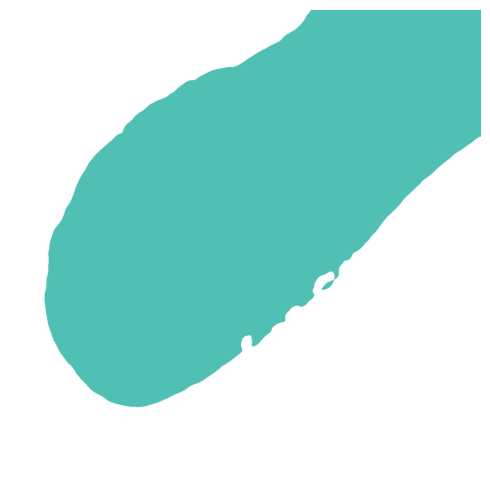

In [ ]:
# Apply Gaussian blur
blurred_image = cv2.GaussianBlur(image, (21, 21), 0)

# Convert the blurred image to grayscale
gray_blurred_image = cv2.cvtColor(blurred_image, cv2.COLOR_RGB2GRAY)

# Perform binary thresholding
_, binary_image = cv2.threshold(gray_blurred_image, 200, 255, cv2.THRESH_BINARY)

# Convert the binary image to RGB format for custom color assignment
binary_image_rgb = np.stack((binary_image,) * 3, axis=-1)
binary_image_rgb[binary_image == 255] = [255, 255, 255]
binary_image_rgb[binary_image == 0] = [0, 0, 255]

# Find connected components and their statistics
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_image, connectivity=8)

# Find the largest connected component
max_area = 0
max_label = 0
for i in range(1, num_labels):
    if stats[i, cv2.CC_STAT_AREA] > max_area:
        max_area = stats[i, cv2.CC_STAT_AREA]
        max_label = i

# Create a mask to retain only the largest connected component
mask = np.zeros_like(binary_image, dtype=np.uint8)
mask[labels == max_label] = 255

# Apply the mask to the RGB image
result_image = binary_image_rgb.copy()
result_image[mask == 0] = [81, 192, 180]
## When exporting, replace [81,192,180] with [180,192,81]
# cv2.imwrite('background2.png', result_image)
# Display the image using matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(result_image)
plt.title('')
plt.axis('off')
plt.show()

### Remove background

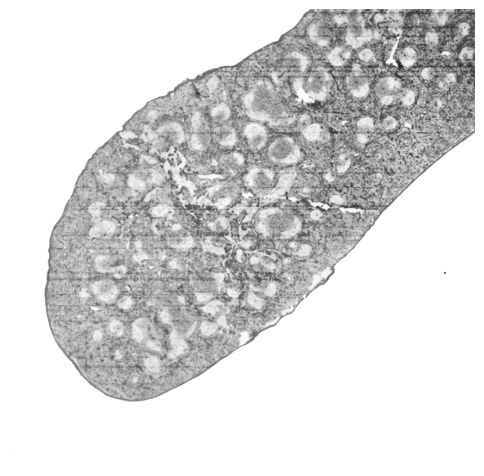

In [ ]:
# Apply Gaussian blur
blurred_image = cv2.GaussianBlur(image, (21, 21), 0)

# Convert the blurred image to grayscale
gray_blurred_image = cv2.cvtColor(blurred_image, cv2.COLOR_RGB2GRAY)

# Find connected components and their statistics
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_image, connectivity=8)

# Find the largest connected component
max_area = 0
max_label = 0
for i in range(1, num_labels):
    if stats[i, cv2.CC_STAT_AREA] > max_area:
        max_area = stats[i, cv2.CC_STAT_AREA]
        max_label = i

# Create a mask to remove the largest connected component (white area)
mask = np.ones_like(binary_image) * 255  # Ensure the mask is a single-channel 8-bit image
mask[labels == max_label] = 0

# Create an image with an alpha channel
image_with_alpha = np.zeros((image.shape[0], image.shape[1], 4), dtype=np.uint8)
image_with_alpha[:, :, 0:3] = image  # Copy RGB values

# Apply the mask to the alpha channel
image_with_alpha[:, :, 3] = mask  # Set black areas to transparent and others to opaque

# Save the image
# cv2.imwrite('transparent_background.png', image_with_alpha)

# Display the image using matplotlib
plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(image_with_alpha, cv2.COLOR_BGRA2RGBA))
plt.title('')
plt.axis('off')
plt.show()